## NG Price Prediction with LSTM Using PyTorch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import the Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [4]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

## Data Plot

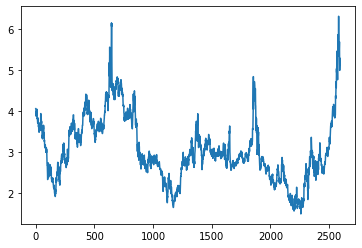

In [5]:
data = pd.read_csv('../data/HistoricalData_NG.csv', index_col=0, sep=',', parse_dates=True)

data = data.sort_index()

data = data.iloc[:,0:1].values

plt.plot(data, label = 'NG Price')
plt.show()


## Preprocess the data

In [7]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [8]:
sc = MinMaxScaler()
data = sc.fit_transform(data)

seq_length = 63
X, y = sliding_windows(data, seq_length)

train_size = int(len(y) * 0.95)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(X)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(X[0:train_size]))).to(device)
y_train = Variable(torch.Tensor(np.array(y[0:train_size]))).to(device)

X_test = Variable(torch.Tensor(np.array(X[train_size:len(X)])))
y_test = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [9]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out[self.num_layers-1].view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Train the Model

In [10]:
num_epochs = 1500
learning_rate = 0.01

input_size = 1
hidden_size = 64
num_layers = 2

lstm = LSTM(input_size, hidden_size, num_layers).to(device)

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(X_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, y_train)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.18324
Epoch: 100, loss: 0.00085
Epoch: 200, loss: 0.00067
Epoch: 300, loss: 0.00056
Epoch: 400, loss: 0.00050
Epoch: 500, loss: 0.00045
Epoch: 600, loss: 0.00041
Epoch: 700, loss: 0.00039
Epoch: 800, loss: 0.00039
Epoch: 900, loss: 0.00037
Epoch: 1000, loss: 0.00037
Epoch: 1100, loss: 0.00037
Epoch: 1200, loss: 0.00037
Epoch: 1300, loss: 0.00037
Epoch: 1400, loss: 0.00036


## Testing out the Model with out of sample predictions

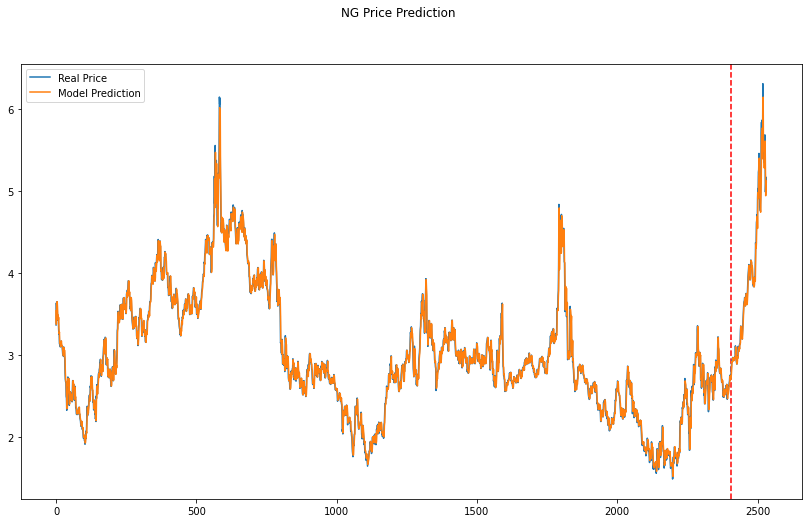

In [11]:
lstm.eval()
train_predict = lstm(dataX.to(device))

data_predict = train_predict.to('cpu').data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

fig, ax = plt.subplots(figsize=(14, 8))
plt.axvline(x=train_size, c='r', linestyle='--')

ax.plot(dataY_plot, label='Real Price')
ax.plot(data_predict, label='Model Prediction')

legend = ax.legend(loc='upper left', fontsize='medium')

plt.suptitle('NG Price Prediction')
plt.show()

## Testing out new predictions



In [12]:
new_X, new_y = sliding_windows(train_predict[train_size:len(X), 0].to('cpu').data.numpy(), seq_length)

new_data_X = Variable(torch.Tensor(np.array(new_X)))
new_data_X = new_data_X.view(new_data_X.shape[0], new_data_X.shape[1], 1)

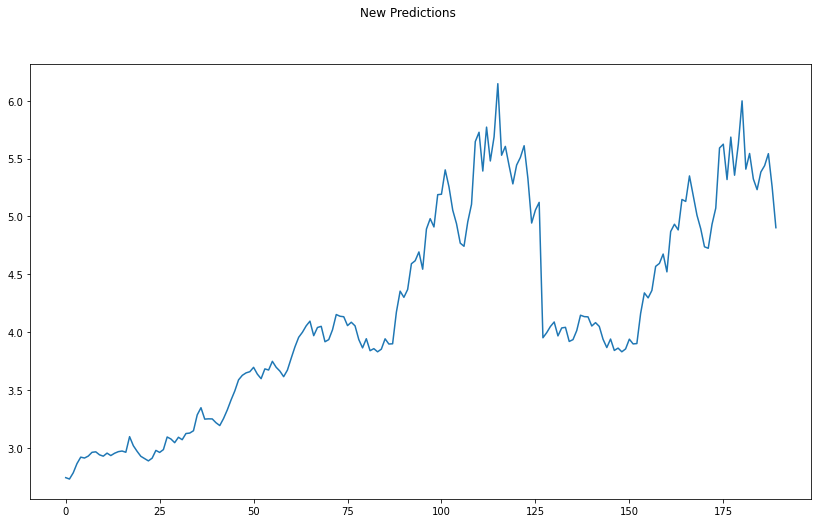

In [13]:
lstm.eval()
new_train_predict = lstm(new_data_X.to(device))

new_data_predict = new_train_predict.to('cpu').data.numpy()

new_data_predict = sc.inverse_transform(new_data_predict)

plt.subplots(figsize=(14, 8))

plt.plot(np.append(data_predict[train_size:len(X)], new_data_predict))
plt.suptitle('New Predictions')
plt.show()